In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn

## Preprocessing

In [2]:
df = pd.read_csv('dataset\wine.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   object 
dtypes: float64(11), object(1)
memory usage: 150.0+ KB


<>:1: SyntaxWarning: invalid escape sequence '\w'
<>:1: SyntaxWarning: invalid escape sequence '\w'
C:\Users\balko\AppData\Local\Temp\ipykernel_10172\3075757770.py:1: SyntaxWarning: invalid escape sequence '\w'
  df = pd.read_csv('dataset\wine.csv')


In [3]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000


<Axes: xlabel='quality', ylabel='Count'>

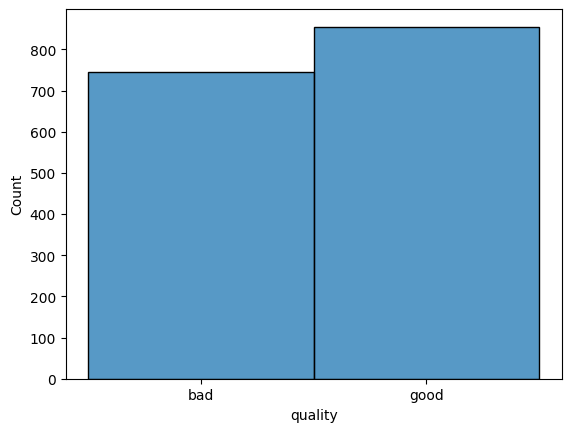

In [4]:
sns.histplot(df, x="quality")

In [5]:
df['quality'] = df['quality'].map({"bad":0,"good":1})
df['quality'].value_counts(normalize=True)

quality
1    0.534709
0    0.465291
Name: proportion, dtype: float64

In [6]:
X = torch.from_numpy(df.drop('quality', axis=1).to_numpy()).to(torch.float32)
y = torch.from_numpy(df['quality'].to_numpy()).to(torch.float32)
X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size=0.2, random_state=4)

In [7]:
print(f"Train: {X_train.shape}, valid: {X_valid.shape[0]}")

Train: torch.Size([1279, 11]), valid: 320


In [8]:
y_train

tensor([0., 1., 0.,  ..., 0., 0., 1.])

In [9]:
BATCH_SIZE=X_train.shape[0]

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

valid_dataset = torch.utils.data.TensorDataset(X_valid, y_valid)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Model

In [10]:
class MyModel(torch.nn.Module):

    def __init__(self):
        super(MyModel, self).__init__()
        self.linear1 = torch.nn.Linear(11,64)
        self.activation1 = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(64, 32)
        self.activation2 = torch.nn.ReLU()
        self.linear3 = torch.nn.Linear(32, 1)
        self.sigmoid = torch.nn.Sigmoid()
    def forward(self, x):
        x = self.linear1(x)
        x = self.activation1(x)
        x = self.linear2(x)
        x = self.activation2(x)
        x = self.linear3(x)
        x = self.sigmoid(x)


        return x.squeeze()

mymodel = MyModel()

In [11]:
print(mymodel)

MyModel(
  (linear1): Linear(in_features=11, out_features=64, bias=True)
  (activation1): ReLU()
  (linear2): Linear(in_features=64, out_features=32, bias=True)
  (activation2): ReLU()
  (linear3): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [12]:
print('\n\nLinear Layer 2 params:')
for param in mymodel.linear2.parameters():
    print(param)



Linear Layer 2 params:
Parameter containing:
tensor([[ 0.0123,  0.0790,  0.0897,  ...,  0.0180, -0.0179,  0.0550],
        [-0.0784,  0.0034, -0.0044,  ...,  0.0096, -0.0999,  0.0661],
        [-0.1168,  0.1042, -0.0217,  ...,  0.0806,  0.1165,  0.1059],
        ...,
        [-0.1013, -0.0596,  0.0629,  ..., -0.0660,  0.0236, -0.0033],
        [ 0.1032,  0.1047, -0.0516,  ..., -0.0405, -0.0731,  0.1211],
        [-0.0218,  0.0640, -0.0136,  ..., -0.0171, -0.1148, -0.0683]],
       requires_grad=True)
Parameter containing:
tensor([-0.0337,  0.1163,  0.1194,  0.0622, -0.0361, -0.0514,  0.0064,  0.0745,
         0.0449,  0.0311, -0.0296, -0.0928,  0.0236,  0.1062, -0.1032, -0.0442,
        -0.0530, -0.0958, -0.0521, -0.0624,  0.0683,  0.0892,  0.0489,  0.0199,
        -0.0754, -0.0960,  0.1188,  0.0339, -0.0295, -0.0304,  0.0073, -0.0985],
       requires_grad=True)


In PyTorch, the nn.Linear module's weights are initialized by default using a method "He initialization.

In [13]:
NUM_EPOCH = 1000

loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(mymodel.parameters(), lr=0.1)

train_loss_list = []
valid_loss_list = []
accuracy_list = []

min_valid_loss = np.inf

for epoch in range(NUM_EPOCH):
    train_loss = 0.0
    mymodel.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        pred = mymodel(inputs)

        loss = loss_fn(pred,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss_list.append(train_loss/len(train_loader))

    mymodel.eval()
    valid_loss, correct = 0, 0
    size = len(valid_loader.dataset)
    with torch.no_grad():
        for inputs, labels in valid_loader:
            pred = mymodel(inputs)
            loss = loss_fn(pred,labels)
            valid_loss += loss.item()
            binary_pred = (pred >= 0.5).float()
            correct += (binary_pred==labels).sum().item()
        correct /= size
        valid_loss/=len(valid_loader)
        accuracy_list.append(correct)
        valid_loss_list.append(valid_loss)


    print(f"Epoch {epoch}: train_loss = {train_loss_list[epoch]}, valid_loss= {valid_loss_list[epoch]}, accuracy= {correct*100}")

   
    


Epoch 0: train_loss = 0.6972163915634155, valid_loss= 2.461817502975464, accuracy= 49.6875
Epoch 1: train_loss = 2.647479295730591, valid_loss= 2.8763670921325684, accuracy= 50.31250000000001
Epoch 2: train_loss = 2.547816753387451, valid_loss= 0.6842871904373169, accuracy= 49.6875
Epoch 3: train_loss = 0.6959829926490784, valid_loss= 0.6762522459030151, accuracy= 60.3125
Epoch 4: train_loss = 0.6803714632987976, valid_loss= 0.6714878082275391, accuracy= 62.81250000000001
Epoch 5: train_loss = 0.6746461391448975, valid_loss= 0.6670371890068054, accuracy= 62.81250000000001
Epoch 6: train_loss = 0.669481098651886, valid_loss= 0.6629763841629028, accuracy= 64.375
Epoch 7: train_loss = 0.664868175983429, valid_loss= 0.6597433090209961, accuracy= 64.375
Epoch 8: train_loss = 0.6609313488006592, valid_loss= 0.6565089225769043, accuracy= 64.375
Epoch 9: train_loss = 0.6577202081680298, valid_loss= 0.6543865203857422, accuracy= 64.375
Epoch 10: train_loss = 0.6548133492469788, valid_loss= 0.65

<Axes: >

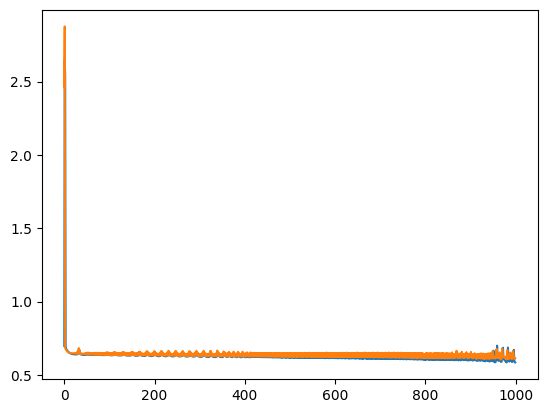

In [14]:
sns.lineplot(train_loss_list)
sns.lineplot(valid_loss_list)

Lets try to improve model 

In [20]:
class MyModel2(torch.nn.Module):
    def __init__(self):
        super(MyModel2, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(11, 512),
            nn.LayerNorm(512),
            nn.SiLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.SiLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 64),
            nn.LayerNorm(64),
            nn.SiLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1),
        )
        self.sigmoid = torch.nn.Sigmoid()
    def forward(self, x):
        x = self.linear_relu_stack(x)
        x = self.sigmoid(x)
        return x.squeeze()

model2 = MyModel2()


In [21]:
NUM_EPOCH = 2000

loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model2.parameters(), lr=0.1, momentum=0.7)

train_loss_list = []
valid_loss_list = []
accuracy_list = []

min_valid_loss = np.inf

for epoch in range(NUM_EPOCH):
    train_loss = 0.0
    model2.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        pred = model2(inputs)

        loss = loss_fn(pred,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss_list.append(train_loss/len(train_loader))

    model2.eval()
    valid_loss, correct = 0, 0
    size = len(valid_loader.dataset)
    with torch.no_grad():
        for inputs, labels in valid_loader:
            pred = model2(inputs)
            loss = loss_fn(pred,labels)
            valid_loss += loss.item()
            binary_pred = (pred >= 0.5).float()
            correct += (binary_pred==labels).sum().item()

        correct /= size
        valid_loss/=len(valid_loader)

        accuracy_list.append(correct)
        valid_loss_list.append(valid_loss)

        if valid_loss < min_valid_loss:
            min_valid_loss = valid_loss
            best_model = model2
            torch.save(model2, 'model/best-model.pt')
            torch.save(model2.state_dict(), 'model/best-model-parameters.pt')

    print(f"Epoch {epoch}: train_loss = {train_loss_list[epoch]}, valid_loss= {valid_loss_list[epoch]}, accuracy= {correct*100}")



Epoch 0: train_loss = 0.7218444347381592, valid_loss= 0.7170211672782898, accuracy= 50.31250000000001
Epoch 1: train_loss = 0.709834635257721, valid_loss= 0.7135025262832642, accuracy= 50.31250000000001
Epoch 2: train_loss = 0.6915879845619202, valid_loss= 0.6973086595535278, accuracy= 50.31250000000001
Epoch 3: train_loss = 0.7022302150726318, valid_loss= 0.6789878606796265, accuracy= 58.12500000000001
Epoch 4: train_loss = 0.6951801776885986, valid_loss= 0.6696682572364807, accuracy= 65.0
Epoch 5: train_loss = 0.6901825666427612, valid_loss= 0.6684672236442566, accuracy= 64.375
Epoch 6: train_loss = 0.6781678795814514, valid_loss= 0.6683262586593628, accuracy= 64.0625
Epoch 7: train_loss = 0.6792460083961487, valid_loss= 0.6698077917098999, accuracy= 63.125
Epoch 8: train_loss = 0.669761598110199, valid_loss= 0.667262852191925, accuracy= 63.4375
Epoch 9: train_loss = 0.6814730167388916, valid_loss= 0.6639288067817688, accuracy= 64.375
Epoch 10: train_loss = 0.6836242079734802, valid_

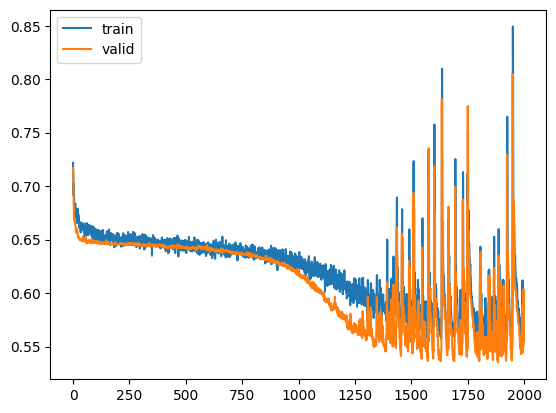

In [22]:
sns.lineplot(train_loss_list, label="train")
sns.lineplot(valid_loss_list, label="valid")
plt.legend()

In [24]:
from torchmetrics.classification import BinaryAccuracy, BinaryF1Score

best_model = MyModel2()
best_model.load_state_dict(torch.load('model/best-model-parameters.pt'))
best_model.eval()
with torch.no_grad():
    pred = best_model(X_valid)

# Convert pred to a float tensor
pred = (pred > 0.5).to(torch.float)

# Calculate accuracy
accuracy = BinaryAccuracy()
f1_score = BinaryF1Score()
print(f"Accuracy: {accuracy(pred, y_valid)}, f1_score: {f1_score(pred, y_valid)}")

Accuracy: 0.734375, f1_score: 0.7118644118309021


**Conclusions**: My model achieved an accuracy of 73,4%, wich is not so good. Maybe we need more data or more comlexity model. Compared to ml algorithms for this dataset, my model gives almost the same results